In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import os
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor, shape, shape2D
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, make_scorer, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
import xgboost as xgb
from sklearn.decomposition import PCA
from collections import defaultdict
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_classif
from PIL import Image
import gc
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from imblearn.over_sampling import SMOTE
import json
import re
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline


d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:

def find_best_threshold(y_true, y_pred_probs):
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_balanced_acc = -1

    for threshold in thresholds:
        y_pred = (y_pred_probs >= threshold).astype(int)
        bal_acc = balanced_accuracy_score(y_true, y_pred)

        if bal_acc > best_balanced_acc:
            best_balanced_acc = bal_acc
            best_threshold = threshold

    return best_threshold

def metrics(y_test, y_pred_probs, threshold):
    y_pred = (y_pred_probs >= threshold).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_probs)
    f1 = f1_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return bal_acc, auc, f1, sensitivity, specificity

def fit_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter=5000, random_state=42, solver='liblinear', class_weight='balanced')
    model.fit(X_train, y_train)
    return model

def bootstrap_metrics(X_train, X_test, y_train, y_test, threshold, n_bootstrap=1000):
    """Performs bootstrap resampling and collects all metrics"""
    
    # Fit model once and get ORs
    model = fit_logistic_regression(X_train, y_train)
    
    boot_auc, boot_bal_acc, boot_sens, boot_spec, boot_f1 = [], [], [], [], []
    
    # Stratified resampling (to ensure label distribution is maintained in each bootstrap sample)
    sss = StratifiedShuffleSplit(n_splits=n_bootstrap, test_size=len(X_test)-5, random_state=42)

    y_pred_probs_full = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for the full test set
    if threshold is None:
        threshold = find_best_threshold(y_test, y_pred_probs_full)
        print(threshold)
    
    for _, test_index in sss.split(X_test, y_test):  # Splitting indices based on stratification
        # Get the stratified bootstrap sample
        sample_df_test = X_test.iloc[test_index]
        sample_dep_test = y_test.iloc[test_index]
        
        # Get predicted probabilities for the resampled test data
        y_pred_probs = model.predict_proba(sample_df_test)[:, 1]
        
        # Compute performance metrics
        bal_acc, auc, f1, sens, spec = metrics(sample_dep_test, y_pred_probs, threshold)
        
        # Append metrics to the lists
        boot_auc.append(auc)
        boot_bal_acc.append(bal_acc)
        boot_sens.append(sens)
        boot_spec.append(spec)
        boot_f1.append(f1)
    
    # Compute means and 95% Confidence Intervals
    def ci(data):
        return np.mean(data), np.percentile(data, [2.5, 97.5])

    return {
        "model": model,
        "Bootstrapped Metrics": {
            "AUC": ci(boot_auc),
            "Balanced Accuracy": ci(boot_bal_acc),
            "Sensitivity": ci(boot_sens),
            "Specificity": ci(boot_spec),
            "F1-score": ci(boot_f1),
        },
        "Arrays with bootstrapping":{
            "AUC": boot_auc,
            "Balanced Accuracy": boot_bal_acc,
            "Sensitivity": boot_sens,
            "Specificity": boot_spec,
            "F1-score": boot_f1,
        }
    }

def load_data(df, label_col="label", drop_cols=None):
    if label_col in df.columns and df[label_col].dtype == 'object':
        df[label_col] = LabelEncoder().fit_transform(df[label_col])
    if drop_cols:
        df = df.drop(columns=drop_cols, errors="ignore")
    return df

# Plot correlation heatmap
def plot_correlation(df, figsize=(12, 8), title="Feature Correlation Heatmap"):
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

# Compute and plot mutual information
def plot_mutual_info(df, label_col="label", top_k=None):
    features = df.drop(columns=[label_col])
    target = df[label_col]
    mi_scores = mutual_info_classif(features, target, discrete_features='auto')
    mi_df = pd.DataFrame({
        "Feature": features.columns,
        "MutualInformation": mi_scores
    }).sort_values(by="MutualInformation", ascending=False)
    
    if top_k:
        mi_df = mi_df.head(top_k)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mi_df, x="MutualInformation", y="Feature", palette="viridis")
    plt.title("Feature Importance via Mutual Information")
    plt.show()
    
    return mi_df

# Plot ROC for stratified vs unstratified split
def compare_roc(df, label_col="label", model=None):
    X = df.drop(columns=[label_col])
    y = df[label_col]
    
    if model is None:
        model = LogisticRegression(max_iter=1000)
    
    # Unstratified
    X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y, test_size=0.3, random_state=42)
    model_u = model.fit(X_train_u, y_train_u)
    y_score_u = model_u.predict_proba(X_test_u)[:, 1]
    fpr_u, tpr_u, _ = roc_curve(y_test_u, y_score_u)
    auc_u = auc(fpr_u, tpr_u)

    # Stratified
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    model_s = model.fit(X_train_s, y_train_s)
    y_score_s = model_s.predict_proba(X_test_s)[:, 1]
    fpr_s, tpr_s, _ = roc_curve(y_test_s, y_score_s)
    auc_s = auc(fpr_s, tpr_s)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_u, tpr_u, label=f"Unstratified (AUC = {auc_u:.2f})", linestyle='--')
    plt.plot(fpr_s, tpr_s, label=f"Stratified (AUC = {auc_s:.2f})", linestyle='-')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve: Stratified vs Unstratified")
    plt.legend()
    plt.grid(True)
    plt.show()


def compare_roc_custom(df, label_col="label", model=None, threshold=0.535, n_bootstrap=1000):
    """
    Compares stratified and unstratified ROC curves using your custom metric + bootstrap functions.
    """
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Default model
    if model is None:
        model = LogisticRegression(max_iter=5000, random_state=42, solver='liblinear', class_weight='balanced')

    ### --- Unstratified split ---
    X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model_u = model.fit(X_train_u, y_train_u)
    y_score_u = model_u.predict_proba(X_test_u)[:, 1]
    
    # ROC + AUC
    fpr_u, tpr_u, _ = roc_curve(y_test_u, y_score_u)
    auc_u = roc_auc_score(y_test_u, y_score_u)
    
    # Custom metrics
    bal_acc_u, auc_custom_u, f1_u, sens_u, spec_u = metrics(y_test_u, y_score_u, threshold)
    print(f"[UNSTRATIFIED] AUC: {auc_custom_u:.3f}, Balanced Acc: {bal_acc_u:.3f}, F1: {f1_u:.3f}, Sens: {sens_u:.3f}, Spec: {spec_u:.3f}")
    
    ### --- Stratified split ---
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    
    results = bootstrap_metrics(X_train_s, X_test_s, y_train_s, y_test_s, threshold, n_bootstrap=n_bootstrap)
    model_s = results["model"]
    y_score_s = model_s.predict_proba(X_test_s)[:, 1]
    
    # ROC + AUC
    fpr_s, tpr_s, _ = roc_curve(y_test_s, y_score_s)
    auc_s = roc_auc_score(y_test_s, y_score_s)
    
    # Print bootstrapped AUC
    auc_mean, auc_ci = results["Bootstrapped Metrics"]["AUC"]
    print(f"[STRATIFIED] Bootstrapped AUC: {auc_mean:.3f} (95% CI: {auc_ci[0]:.3f}–{auc_ci[1]:.3f})")

    ### --- Plot ---
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_u, tpr_u, label=f"Unstratified (AUC = {auc_u:.2f})", linestyle='--', color='blue')
    plt.plot(fpr_s, tpr_s, label=f"Stratified (AUC = {auc_s:.2f})", linestyle='-', color='green')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve: Stratified vs Unstratified")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results

[UNSTRATIFIED] AUC: 0.583, Balanced Acc: 0.540, F1: 0.467, Sens: 0.447, Spec: 0.634
[STRATIFIED] Bootstrapped AUC: 0.617 (95% CI: 0.607–0.628)


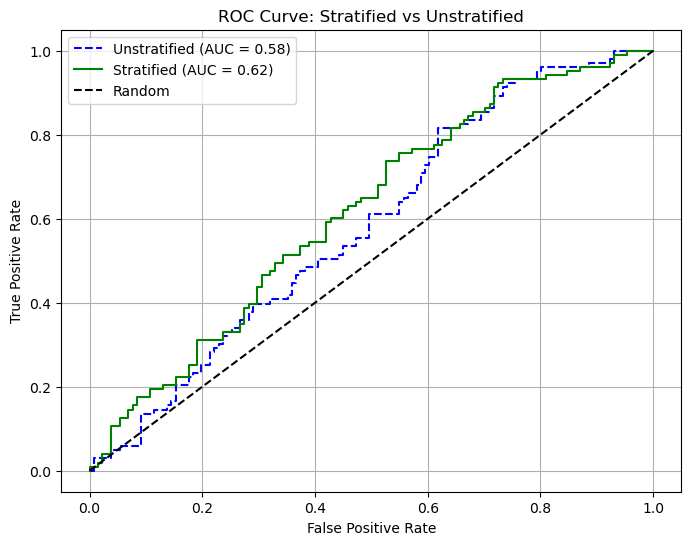

{'model': LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42,
                    solver='liblinear'),
 'Bootstrapped Metrics': {'AUC': (0.6166629486386138,
   array([0.60674312, 0.62801671])),
  'Balanced Accuracy': (0.5550667388613861, array([0.54567605, 0.56338954])),
  'Sensitivity': (0.4078772277227723, array([0.3960396 , 0.41584158])),
  'Specificity': (0.70225625, array([0.6953125, 0.71875  ])),
  'F1-score': (0.45693618226097743, array([0.44444444, 0.46666667]))},
 'Arrays with bootstrapping': {'AUC': [0.6236076732673267,
   0.6132425742574259,
   0.6157951732673268,
   0.6142481435643564,
   0.6137840346534653,
   0.6157178217821783,
   0.6150216584158417,
   0.6083694306930694,
   0.6161045792079207,
   0.6171101485148516,
   0.6168007425742575,
   0.6085241336633664,
   0.6260829207920793,
   0.6212871287128714,
   0.6172648514851486,
   0.6178063118811882,
   0.6130878712871286,
   0.6171101485148516,
   0.6205909653465348,
   0.618966584158416,
   0

In [17]:
df_features = pd.read_csv("Data/Radiomic_features/features_resampled2_bin5.csv")
df_marksheet = pd.read_csv("Data/Preprocessed_marksheet_all.csv")

df_csPCa = df_marksheet.drop(columns=["study_id", "mri_date", "patient_age", "psa", "psad", "prostate_volume", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])
df_features.drop(columns=["Unnamed: 0"], inplace=True)

merge_df = pd.merge(df_csPCa, df_features, on="patient_id", how="left")
merge_df = merge_df.dropna()

df = load_data(merge_df, label_col="case_csPCa", drop_cols=["patient_id"])

# 1. Visualize correlation

# 3. Compare ROC curves (uses LogisticRegression by default)
compare_roc_custom(df, label_col="case_csPCa", model=None, threshold=0.535, n_bootstrap=5000)

[UNSTRATIFIED] AUC: 0.701, Balanced Acc: 0.654, F1: 0.567, Sens: 0.546, Spec: 0.762
[STRATIFIED] Bootstrapped AUC: 0.706 (95% CI: 0.699–0.715)


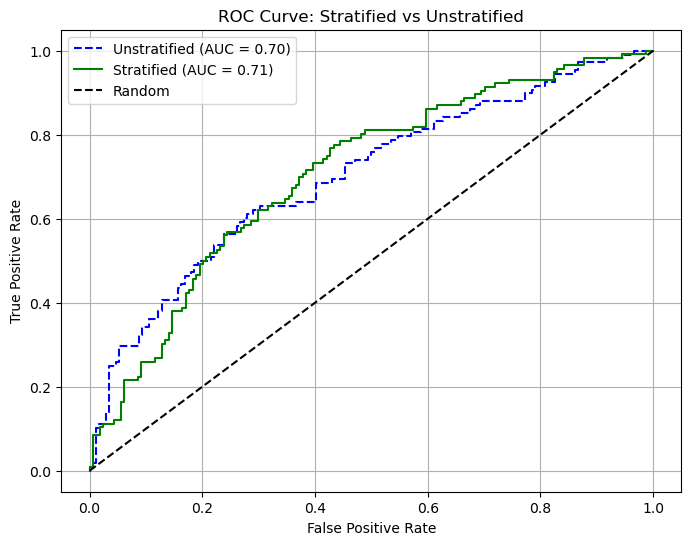

{'model': LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42,
                    solver='liblinear'),
 'Bootstrapped Metrics': {'AUC': (0.706434706331045,
   array([0.69930124, 0.71543124])),
  'Balanced Accuracy': (0.6458367331371909, array([0.63947913, 0.65446224])),
  'Sensitivity': (0.5172771929824563, array([0.50877193, 0.52631579])),
  'Specificity': (0.7743962732919255, array([0.77018634, 0.7826087 ])),
  'F1-score': (0.5635062061669741, array([0.55502392, 0.57416268]))},
 'Arrays with bootstrapping': {'AUC': [0.7092731829573935,
   0.7079110820529585,
   0.7065489811485235,
   0.7054593004249754,
   0.707311757655007,
   0.7082924703062004,
   0.705241364280266,
   0.7052958483164433,
   0.6998474446987033,
   0.7055137844611529,
   0.7095456031382804,
   0.7092731829573935,
   0.7054593004249755,
   0.7011005775307835,
   0.7051868802440885,
   0.7044241037376049,
   0.702680614579928,
   0.7107987359703607,
   0.7065489811485235,
   0.709218698921216,

In [18]:
# Load dataset
df_marksheet = pd.read_csv("Data/Preprocessed_marksheet_all.csv")


df = load_data(df_marksheet, label_col="case_csPCa", drop_cols=["patient_id", "study_id", "mri_date", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])


# 3. Compare ROC curves (uses LogisticRegression by default)
compare_roc_custom(df, label_col="case_csPCa", model=None, threshold=0.535, n_bootstrap=5000)

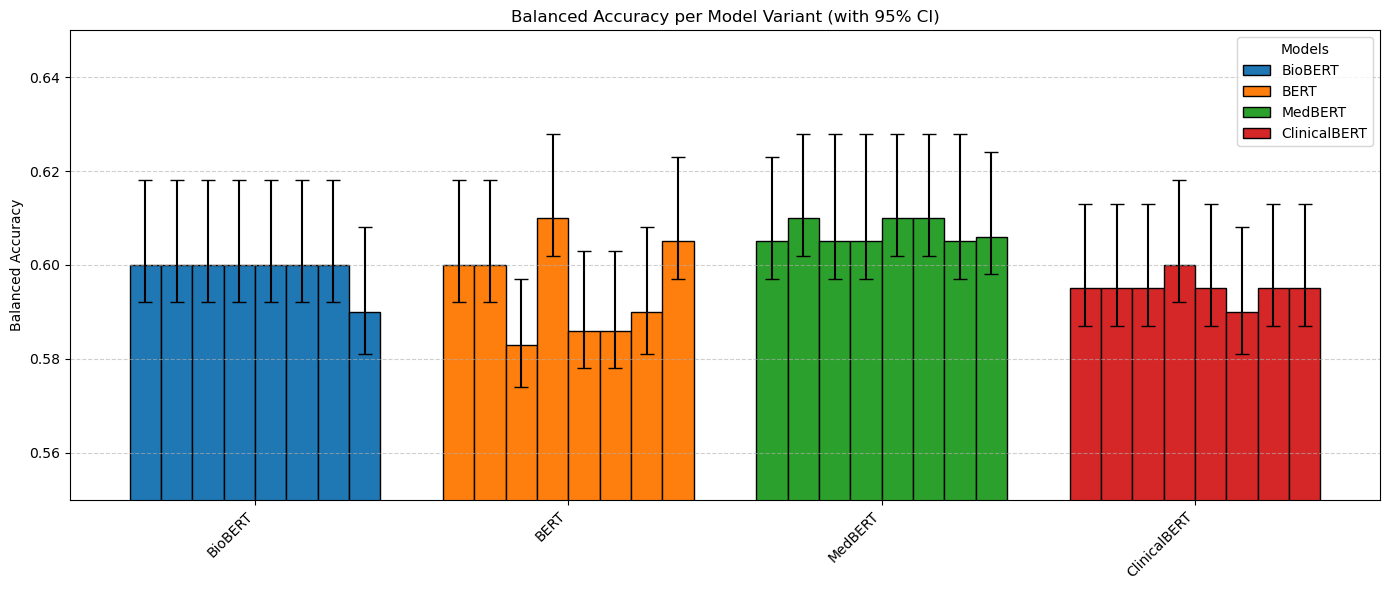

In [ ]:


models = ['BioBERT', 'BERT', 'MedBERT', 'ClinicalBERT']
# Balanced Accuracy data: (mean, lower bound, upper bound)
balanced_accuracy_data = {
    'BioBERT': [(0.600, 0.608, 0.618)] * 7 + [(0.590, 0.599, 0.608)],
    'BERT': [
        (0.600, 0.608, 0.618), (0.600, 0.608, 0.618), (0.583, 0.592, 0.597),
        (0.610, 0.618, 0.628), (0.586, 0.594, 0.603), (0.586, 0.594, 0.603),
        (0.590, 0.599, 0.608), (0.605, 0.613, 0.623)
    ],
    'MedBERT': [
        (0.605, 0.613, 0.623), (0.610, 0.618, 0.628), (0.605, 0.613, 0.628),
        (0.605, 0.613, 0.628), (0.610, 0.618, 0.628), (0.610, 0.618, 0.628),
        (0.605, 0.613, 0.628), (0.606, 0.614, 0.624)
    ],
    'ClinicalBERT': [
        (0.595, 0.603, 0.613), (0.595, 0.603, 0.613), (0.595, 0.603, 0.613),
        (0.600, 0.608, 0.618), (0.595, 0.603, 0.613), (0.590, 0.599, 0.608),
        (0.595, 0.603, 0.613), (0.595, 0.603, 0.613)
    ]
}

# Plot settings
num_variants = max(len(v) for v in balanced_accuracy_data.values())
bar_width = 0.1
group_gap = 0.2
colors = plt.cm.tab10.colors

# Compute bar positions and errors
x_positions = []
means, lower_err, upper_err, bar_colors = [], [], [], []
group_centers = []
current_x = 0

for model_index, (model, variants) in enumerate(balanced_accuracy_data.items()):
    base_x = current_x
    group_centers.append(base_x + (len(variants) - 1) * bar_width / 2)
    
    for i, (mean, low, high) in enumerate(variants):
        x = base_x + i * bar_width
        x_positions.append(x)
        means.append(mean)
        lower_err.append(low - mean)
        upper_err.append(high - mean)
        bar_colors.append(colors[model_index % len(colors)])
    
    current_x += len(variants) * bar_width + group_gap

# Plotting
plt.figure(figsize=(14, 6))
bars = plt.bar(
    x_positions, means,
    yerr=[lower_err, upper_err],
    capsize=5, width=bar_width,
    color=bar_colors, edgecolor='black'
)

plt.xticks(group_centers, list(balanced_accuracy_data.keys()), rotation=45, ha='right')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy per Model Variant (with 95% CI)')
plt.ylim(0.55, 0.65)
plt.grid(axis='y', linestyle='--', alpha=0.6)

legend_elements = [
    Patch(facecolor=colors[i % len(colors)], edgecolor='black', label=model) 
    for i, model in enumerate(balanced_accuracy_data.keys())
]
plt.legend(handles=legend_elements, title="Models", loc="upper right")

plt.tight_layout()
plt.show()

[Radiomic] AUC: 0.617, Balanced Acc: 0.555, F1: 0.457, Sens: 0.408, Spec: 0.702
[Clinical] AUC: 0.707, Balanced Acc: 0.642, F1: 0.557, Sens: 0.509, Spec: 0.774
[BioBERT] AUC: 0.640, Balanced Acc: 0.614, F1: 0.509, Sens: 0.427, Spec: 0.802
[BERT] AUC: 0.640, Balanced Acc: 0.614, F1: 0.509, Sens: 0.427, Spec: 0.802
[MedBERT] AUC: 0.640, Balanced Acc: 0.620, F1: 0.523, Sens: 0.447, Spec: 0.794
[ClinicalBERT] AUC: 0.640, Balanced Acc: 0.614, F1: 0.509, Sens: 0.427, Spec: 0.802


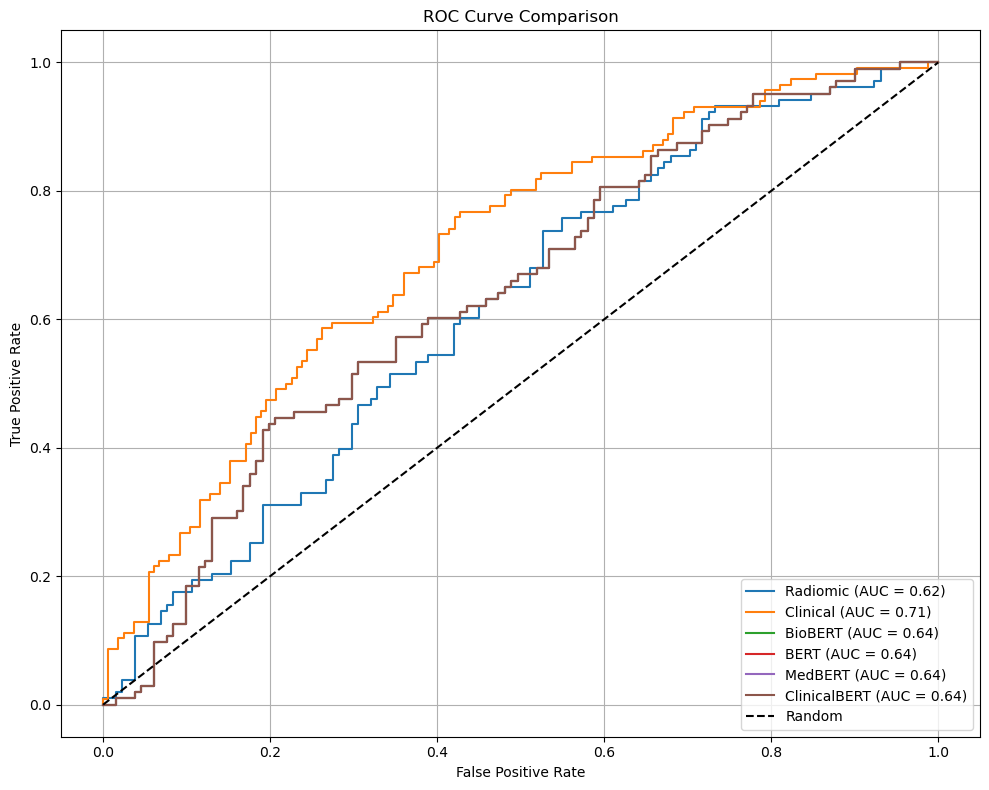

In [10]:
def compare_models_roc(
    model_dict,  # e.g., {'Radiomic': radiomic_df, 'BioBERT': bio_df, ...}
    label_col="case_csPCa",
    threshold=0.535,
    n_bootstrap=1000
):
    """
    Plots ROC curves for multiple models using stratified train/test splits.

    Parameters:
        model_dict (dict): keys are model names, values are DataFrames (features + label_col)
        label_col (str): name of the label column
        threshold (float): threshold for computing custom metrics
        n_bootstrap (int): number of bootstrap iterations for metrics
    """
    plt.figure(figsize=(10, 8))
    
    for model_name, df in model_dict.items():
        if model_name == "Clinical" or model_name == "Radiomic":
            # For Clinical and Radiomic, we need to drop the patient_id column
            X = df.drop(columns=[label_col])
            y = df[label_col]
        else:

            X = np.vstack(df["combined_embedding"].apply(lambda x: np.array(json.loads(x))).values)
            y = df[label_col].values
            X = pd.DataFrame(X)
            y = pd.Series(y)
        # Stratified split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=42
        )

        # Train model
        model = LogisticRegression(max_iter=5000, random_state=42, solver='liblinear', class_weight='balanced')
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:, 1]

        # ROC & AUC
        fpr, tpr, _ = roc_curve(y_test, y_score)
        auc = roc_auc_score(y_test, y_score)

        # Custom metrics
        bal_acc, auc_custom, f1, sens, spec = metrics(y_test, y_score, threshold)
        print(f"[{model_name}] AUC: {auc:.3f}, Balanced Acc: {bal_acc:.3f}, F1: {f1:.3f}, Sens: {sens:.3f}, Spec: {spec:.3f}")
        
        # Plot ROC
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

clinical_df = pd.read_csv("Data/Preprocessed_marksheet_all.csv")
clinical_df = clinical_df.drop(columns=["study_id", "mri_date", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])
df_csPCa = clinical_df[["patient_id", "case_csPCa"]].copy()

radiomic_df = pd.read_csv("Data/Radiomic_features/features_resampled2_bin5.csv")
radiomic_df = pd.merge(df_csPCa, radiomic_df, on="patient_id", how="left")
radiomic_df = radiomic_df.drop(columns=["Unnamed: 0","patient_id"])
radiomic_df.dropna(inplace=True)

biobert_df = pd.read_csv("Data/embeddings/BioBERT_3/BioBERT_Yes_Yes_Yes.csv")
biobert_df = pd.merge(df_csPCa, biobert_df, on="patient_id", how="left")
biobert_df = biobert_df.drop(columns=["patient_id"])
biobert_df.dropna(inplace=True)

bert_df = pd.read_csv("Data/embeddings/BERT_3/BERT_Yes_Yes_Yes.csv")
bert_df = pd.merge(df_csPCa, bert_df, on="patient_id", how="left")
bert_df = bert_df.drop(columns=["patient_id"])
bert_df.dropna(inplace=True)

medbert_df = pd.read_csv("Data/embeddings/MedBERT_3/MedBERT_Yes_No_No.csv")
medbert_df = pd.merge(df_csPCa, medbert_df, on="patient_id", how="left")
medbert_df = medbert_df.drop(columns=["patient_id"])
medbert_df.dropna(inplace=True)

clinicalbert_df = pd.read_csv("Data/embeddings/ClinicalBERT_3/ClinicalBERT_Yes_Yes_Yes.csv")
clinicalbert_df = pd.merge(df_csPCa, clinicalbert_df, on="patient_id", how="left")
clinicalbert_df = clinicalbert_df.drop(columns=["patient_id"])
clinicalbert_df.dropna(inplace=True)
model_dict = {
    "Radiomic": radiomic_df,
    "Clinical": clinical_df,
    "BioBERT": biobert_df,
    "BERT": bert_df,
    "MedBERT": medbert_df,
    "ClinicalBERT": clinicalbert_df
}

compare_models_roc(model_dict)

[Radiomic] Balanced Acc: 0.555, F1: 0.457, Sens: 0.408, Spec: 0.702
[Clinical] Balanced Acc: 0.642, F1: 0.557, Sens: 0.509, Spec: 0.774
[MedBERT] Balanced Acc: 0.620, F1: 0.523, Sens: 0.447, Spec: 0.794


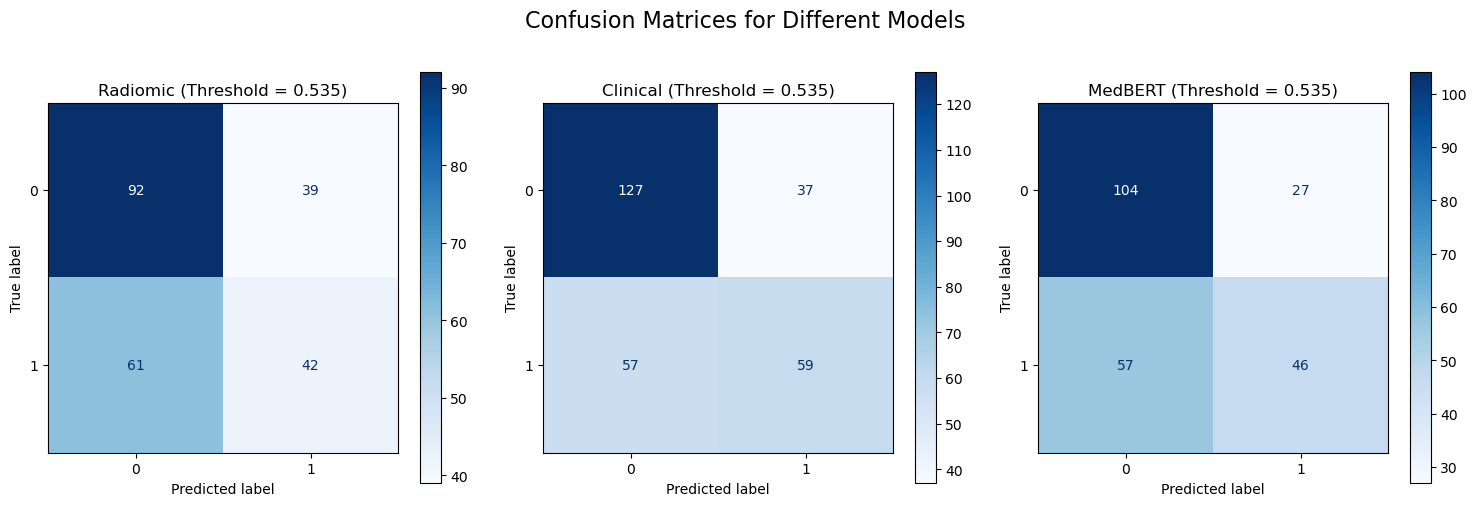

In [12]:
def compare_models_confusion(
    model_dict,
    label_col="case_csPCa",
    threshold=0.535
):
    """
    Trains models and displays confusion matrices for multiple feature sets.

    Parameters:
        model_dict (dict): keys are model names, values are DataFrames (features + label_col)
        label_col (str): name of the label column
        threshold (float): classification threshold
    """
    n_models = len(model_dict)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for idx, (model_name, df) in enumerate(model_dict.items()):
        if model_name in ["Clinical", "Radiomic"]:
            X = df.drop(columns=[label_col])
            y = df[label_col]
        else:
            X = np.vstack(df["combined_embedding"].apply(lambda x: np.array(json.loads(x))).values)
            y = df[label_col].values
            X = pd.DataFrame(X)
            y = pd.Series(y)

        # Stratified split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, stratify=y, random_state=42
        )

        # Train model
        model = LogisticRegression(max_iter=5000, random_state=42, solver='liblinear', class_weight='balanced')
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:, 1]
        y_pred = (y_score >= threshold).astype(int)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(ax=axes[idx], values_format='d', cmap="Blues")
        axes[idx].set_title(f"{model_name} (Threshold = {threshold})")

        # Optional: print metrics to console
        bal_acc, auc_custom, f1, sens, spec = metrics(y_test, y_score, threshold)
        print(f"[{model_name}] Balanced Acc: {bal_acc:.3f}, F1: {f1:.3f}, Sens: {sens:.3f}, Spec: {spec:.3f}")

    # Hide unused subplots if any
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Confusion Matrices for Different Models", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

clinical_df = pd.read_csv("Data/Preprocessed_marksheet_all.csv")
clinical_df = clinical_df.drop(columns=["study_id", "mri_date", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])
df_csPCa = clinical_df[["patient_id", "case_csPCa"]].copy()

radiomic_df = pd.read_csv("Data/Radiomic_features/features_resampled2_bin5.csv")
radiomic_df = pd.merge(df_csPCa, radiomic_df, on="patient_id", how="left")
radiomic_df = radiomic_df.drop(columns=["Unnamed: 0","patient_id"])
radiomic_df.dropna(inplace=True)

biobert_df = pd.read_csv("Data/embeddings/BioBERT_3/BioBERT_Yes_Yes_Yes.csv")
biobert_df = pd.merge(df_csPCa, biobert_df, on="patient_id", how="left")
biobert_df = biobert_df.drop(columns=["patient_id"])
biobert_df.dropna(inplace=True)

bert_df = pd.read_csv("Data/embeddings/BERT_3/BERT_Yes_Yes_Yes.csv")
bert_df = pd.merge(df_csPCa, bert_df, on="patient_id", how="left")
bert_df = bert_df.drop(columns=["patient_id"])
bert_df.dropna(inplace=True)

medbert_df = pd.read_csv("Data/embeddings/MedBERT_3/MedBERT_Yes_No_No.csv")
medbert_df = pd.merge(df_csPCa, medbert_df, on="patient_id", how="left")
medbert_df = medbert_df.drop(columns=["patient_id"])
medbert_df.dropna(inplace=True)

clinicalbert_df = pd.read_csv("Data/embeddings/ClinicalBERT_3/ClinicalBERT_Yes_Yes_Yes.csv")
clinicalbert_df = pd.merge(df_csPCa, clinicalbert_df, on="patient_id", how="left")
clinicalbert_df = clinicalbert_df.drop(columns=["patient_id"])
clinicalbert_df.dropna(inplace=True)
model_dict = {
    "Radiomic": radiomic_df,
    "Clinical": clinical_df,
    "MedBERT": medbert_df,
}
compare_models_confusion(model_dict, label_col="case_csPCa", threshold=0.535)